In [ ]:
#Dataset from https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import linear_model, model_selection
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

##Reading Datasets

In [10]:
fake = pd.read_csv("./Fake.csv")
real = pd.read_csv("./Real.csv")

In [11]:
fake.shape

(23481, 4)

In [12]:
real.shape

(21417, 4)

##Preparing and cleaning the data

In [14]:
#Setting a flag to distinguish between real and fake datasets
fake['target'] = 'fake'
real['target'] = 'real'

In [15]:
# Concatenating the dataframes
data = pd.concat([fake, real]).reset_index(drop=True)
data.shape

# Shuffling the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

data.head()

,title,text,subject,date,target
0,"Striking French workers disrupt flights, schools",PARIS (Reuters) - French public sector workers...,worldnews,"October 10, 2017",real
1,Senate panel backs Trump National Security Adv...,WASHINGTON (Reuters) - The U.S. Senate Armed S...,politicsNews,"March 7, 2017",real
2,Michigan’s Republican Governor Needs Your Tax...,The water crisis in Flint is not just simply a...,News,"January 10, 2016",fake
3,TRUMP GETS HAMMERED [Video] For Not Condemning...,"Yeah, because taking Trump down is more import...",politics,"Sep 18, 2015",fake
4,Obama's trip aims to make Cuba opening 'irreve...,WASHINGTON (Reuters) - President Barack Obama ...,politicsNews,"March 16, 2016",real


In [16]:
#Removing the date from the data
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,"Striking French workers disrupt flights, schools",PARIS (Reuters) - French public sector workers...,worldnews,real
1,Senate panel backs Trump National Security Adv...,WASHINGTON (Reuters) - The U.S. Senate Armed S...,politicsNews,real
2,Michigan’s Republican Governor Needs Your Tax...,The water crisis in Flint is not just simply a...,News,fake
3,TRUMP GETS HAMMERED [Video] For Not Condemning...,"Yeah, because taking Trump down is more import...",politics,fake
4,Obama's trip aims to make Cuba opening 'irreve...,WASHINGTON (Reuters) - President Barack Obama ...,politicsNews,real


In [17]:
#Removing the titles
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,PARIS (Reuters) - French public sector workers...,worldnews,real
1,WASHINGTON (Reuters) - The U.S. Senate Armed S...,politicsNews,real
2,The water crisis in Flint is not just simply a...,News,fake
3,"Yeah, because taking Trump down is more import...",politics,fake
4,WASHINGTON (Reuters) - President Barack Obama ...,politicsNews,real


In [18]:
#Converting to lowercase
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,paris (reuters) - french public sector workers...,worldnews,real
1,washington (reuters) - the u.s. senate armed s...,politicsNews,real
2,the water crisis in flint is not just simply a...,News,fake
3,"yeah, because taking trump down is more import...",politics,fake
4,washington (reuters) - president barack obama ...,politicsNews,real


In [19]:
#Removing punctuation
import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)
data.head()

,text,subject,target
0,paris reuters french public sector workers we...,worldnews,real
1,washington reuters the us senate armed servic...,politicsNews,real
2,the water crisis in flint is not just simply a...,News,fake
3,yeah because taking trump down is more importa...,politics,fake
4,washington reuters president barack obama pla...,politicsNews,real


In [20]:
#Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

data.head()

[nltk_data] Downloading package stopwords to /home/mohit/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,subject,target
0,paris reuters french public sector workers wen...,worldnews,real
1,washington reuters us senate armed services co...,politicsNews,real
2,water crisis flint simply manmade disaster act...,News,fake
3,yeah taking trump important flame throwers lef...,politics,fake
4,washington reuters president barack obama plan...,politicsNews,real


##Exploring the data

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


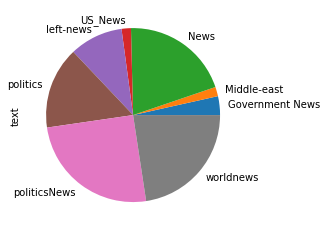

In [21]:
#Number of articles per subject
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="pie")
plt.show()

target
fake    23481
real    21417
Name: text, dtype: int64


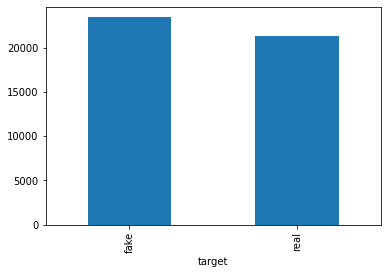

In [22]:
#Number of fake and real articles
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

In [30]:
#Counting the most frequently occuring words   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()), "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'red')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

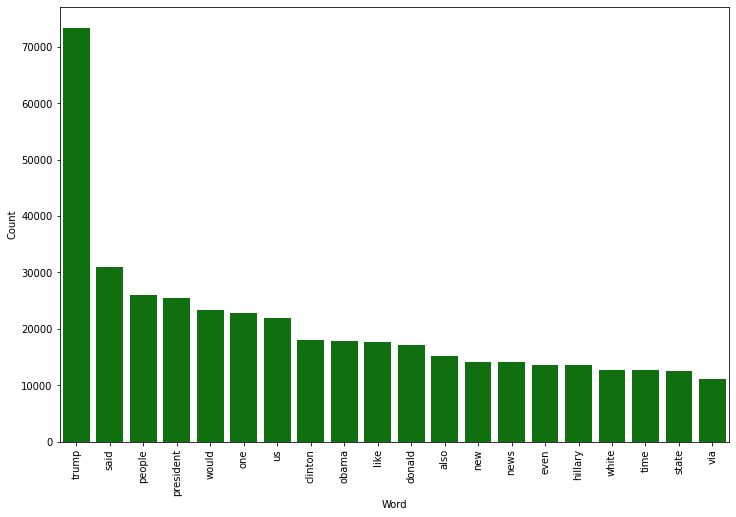

In [29]:
# Most frequently occuring words in FAKE news
counter(data[data["target"] == "fake"], "text", 20)

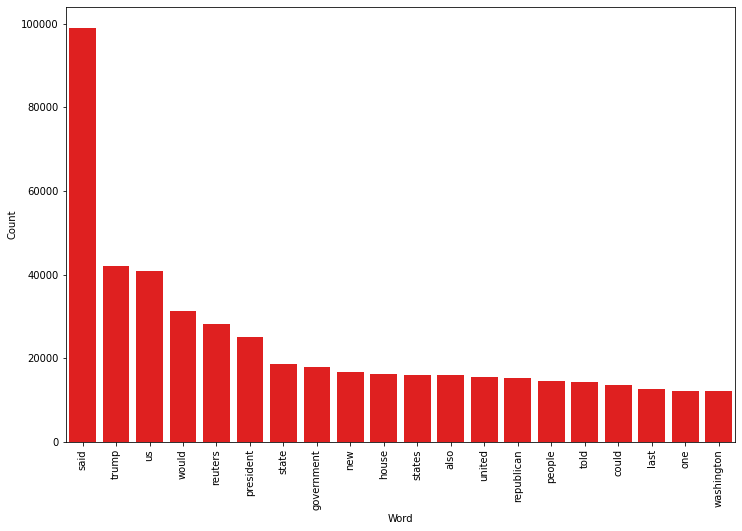

In [31]:
# Most frequently occurring words in REAL news
counter(data[data["target"] == "real"], "text", 20)

In [25]:
#Vectorizing and applying TF-IDF
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.8, random_state=45)
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

#Fitting the model
model = pipe.fit(X_train, y_train)

#Accuracy
prediction = model.predict(X_test)
print("Model Accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

Model Accuracy: 97.77%
